In [1]:
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import math
import sklearn
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
import gzip

fp = gzip.open('fashion-mnist.pk.gz','rb')
Xtrain, Ytrain, Xtest, Ytest, classlist  = pickle.load(fp)

In [3]:
train_X = Xtrain.numpy().reshape(60000,-1)
train_Y = Ytrain.numpy().reshape(60000,1)
pdtrainX = pd.DataFrame(train_X)
pdtrainY = pd.DataFrame(train_Y)
pdtrainY.columns = ['label']
train = pd.concat([pdtrainX,pdtrainY],axis=1)

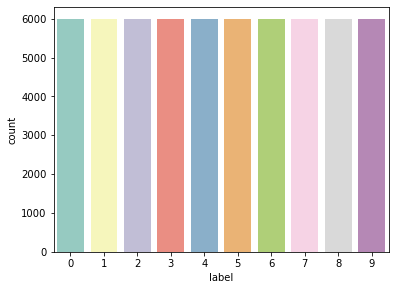

In [4]:
plt.figure(figsize = (6,4.5))
ax = sns.countplot(x = 'label', data = train, palette = 'Set3')

(527, 784)

The component PC 0 explains  22.083544731140137 % of the variance
The component PC 1 explains  14.414630830287933 % of the variance
The component PC 2 explains  5.461176857352257 % of the variance
The component PC 3 explains  5.088688060641289 % of the variance
The component PC 4 explains  4.054888337850571 % of the variance
The component PC 5 explains  3.0195090919733047 % of the variance
The component PC 6 explains  2.7475403621792793 % of the variance
The component PC 7 explains  2.3136531934142113 % of the variance
The component PC 8 explains  1.6926394775509834 % of the variance
The component PC 9 explains  1.3180430047214031 % of the variance
The component PC 10 explains  1.1701025068759918 % of the variance
The component PC 11 explains  0.9623636491596699 % of the variance
The component PC 12 explains  0.9064405225217342 % of the variance
The component PC 13 explains  0.8610055781900883 % of the variance
The component PC 14 explains  0.7430077530443668 % of the variance
and so o

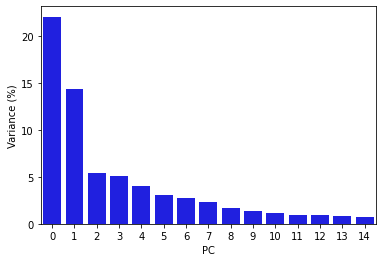

In [5]:
from sklearn.preprocessing import StandardScaler
labels = pdtrainY.values.T
train_N = StandardScaler().fit_transform(pdtrainX)
from sklearn.decomposition import PCA
pca = PCA(.99)
pca.fit(train_N)
########################################
display(pca.components_.shape)
PC = []
var = pca.explained_variance_ratio_[0:15]*100
for k in range(15):
    PC.append(k)
    print('The component PC',k, 'explains ',pca.explained_variance_ratio_[k]*100,'% of the variance')
print('and so on......')
variance = pd.DataFrame({'Variance (%)':var,'PC':PC})
sns.barplot(x='PC',y="Variance (%)", data=variance, color="b")

(60000, 2)


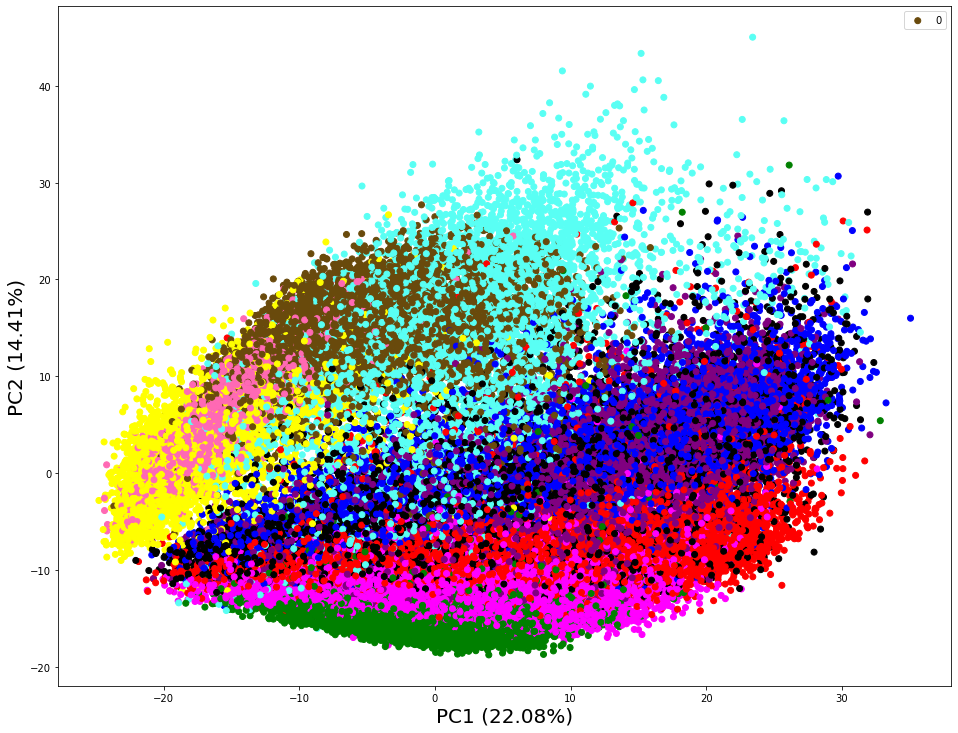

In [6]:
aux_list = [0,1,2,3,4,5,6,7,8,9]
P=pca.transform(train_N)[:,0:2] # top two components
print(P.shape)
plt.figure(figsize=(16,12.5))
label_color_dict = {0:'red',1:'green',2:'blue',3:'magenta',4:'purple',
                   5:'yellow',6:'black',7:'#ff69b4',8:'#59fff4',9:'#694a0c'}
cvc = []
for v in range(60000):
    cvc.append(label_color_dict[int(train_Y[v])])
#print(cvc)
scatter=plt.scatter(P[:,0], P[:,1], c=cvc[:])
plt.xlabel(r'PC1 (22.08%)',fontsize=20)
plt.ylabel(r'PC2 (14.41%)',fontsize=20)
plt.legend(label_color_dict)

In [7]:
x_train = (th.from_numpy(pca.transform(train_N)).float()).cuda()
y_train = (Ytrain).cuda()

In [8]:
test_N = StandardScaler().fit_transform(Xtest)
x_test = (th.from_numpy(pca.transform(test_N)).float()).cuda()
y_test = (Ytest).cuda()

In [9]:
display(x_train.shape)
display(y_train.shape)
display(x_test.shape)
display(y_test.shape)

torch.Size([60000, 527])

torch.Size([60000])

torch.Size([10000, 527])

torch.Size([10000])

In [10]:
def train(model,optimizer,loss_fn,epochs,batch_size,Xtrain,Ytrain,Xtest,Ytest,verbose=False):
    ### Mini-batching and shuffle 
    Ntrain = Xtrain.shape[0]
    Nvalid = Xtest.shape[0]
    idx = np.arange(Ntrain)              # Number of samples that we treat before update the gradient such as in descent gradient, a trade-off between batch and gradient descent methods
    nbatch = int(Ntrain/batch_size)
    
    train_losses,valid_losses, valid_accuracies=[],[],[]
    for e in range(epochs):
        np.random.shuffle(idx)
        running_loss=0
        totaln = 0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            images = Xtrain[ids]
            labels = Ytrain[ids]
            totaln += labels.shape[0] # the number of samples
            optimizer.zero_grad()
            logprobs=model(images)
            loss=loss_fn(logprobs,labels)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
        # training is over for one epoch
        # now compute interesting quantities
        accuracy=0
        valid_loss = 0        
        with th.no_grad(): # From here, we ignore the gradient in calculations with tensors, which will increase the speed of the code
            images = Xtest.cuda()   # We are going to valid the model
            labels = Ytest.cuda()
            logprobs=model(images.float()).cuda()
            valid_loss=loss_fn(logprobs,labels)
            top_p,top_class=logprobs.topk(1)   # topk function will take the predicted class according to the model that we used
            accuracy=(top_class.T == labels).sum().float()
        train_losses.append(running_loss/batch_size)
        valid_losses.append(valid_loss)
        valid_accuracies.append(accuracy.item()*100.0/Nvalid)
    print('Training/Validation done')
        #print("Epoch: {}\t".format(e),"train Loss: {:.5f}.. ".format(train_losses[-1]), "valid Loss: {:.5f}.. ".format(valid_losses[-1]),"valid Accuracy: {:.3f}".format(valid_accuracies[-1]))  
    #print("---------- Best : {:.3f}".format(max(valid_accuracies)), " at epoch " , np.fromiter(valid_accuracies, dtype=np.float).argmax(), " / ",epochs )
    #plt.figure(figsize = (6, 4.5))
    #plt.plot(train_losses)
    #plt.ylim(bottom=0)
    #plt.show()
    #plt.figure(figsize = (6, 4.5))
    #plt.plot(valid_losses)
    #plt.ylim(bottom=0)
    #plt.show()
    #plt.figure(figsize = (6, 4.5))
    #plt.plot(valid_accuracies)
    #plt.ylim(bottom=0)
    #plt.show()
    return max(valid_accuracies) , np.fromiter(valid_accuracies, dtype=np.float).argmax()

In [25]:
epochs=20
### The model, the loss and optimizer
D_in = 527
D_out= 10
batch_size = 50
MAX_ACC, IN_EPOCH, BATCH_SIZE = [], [], []

for k in range(40):
    model=nn.Sequential(nn.Linear(D_in,D_out),
                    nn.LogSoftmax(dim=1)).cuda()
    optimizer=th.optim.Adam(model.parameters(),lr=0.005)
    loss_fn=nn.NLLLoss()
    max_acc, EPOCH = train(model,optimizer,loss_fn,epochs,batch_size,x_train,y_train,x_test,y_test)
    MAX_ACC.append(max_acc)
    IN_EPOCH.append(EPOCH)
    BATCH_SIZE.append(batch_size)
    batch_size = batch_size + 50

Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done


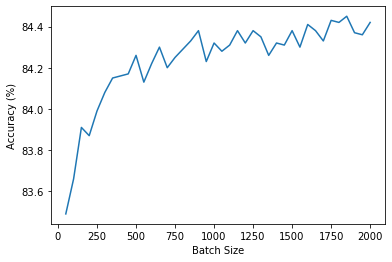

The best accuracy was 84.45 % for 1850 batches


In [26]:
plt.plot(BATCH_SIZE,MAX_ACC)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.show()
print('The best accuracy was' , max(MAX_ACC),'% for',  BATCH_SIZE[MAX_ACC.index(max(MAX_ACC))], 'batches')

# Using one hidden layer

In [27]:
# Using 425 as batch size

epochs=20
### The model, the loss and optimizer
D_in = 527
D_1 = 10
D_out= 10
batch_size = 2000
MAX_ACC, IN_EPOCH, N_D1 = [], [], []

for k in range(50):
    model=nn.Sequential(nn.Linear(D_in,D_1),
                    nn.Sigmoid(),
                    nn.Linear(D_1,D_out),
                    nn.LogSoftmax(dim=1)).cuda()

    optimizer=th.optim.Adam(model.parameters(),lr=0.005)
    loss_fn=nn.NLLLoss()
    max_acc, EPOCH = train(model,optimizer,loss_fn,epochs,batch_size,x_train,y_train,x_test,y_test)
    MAX_ACC.append(max_acc)
    IN_EPOCH.append(EPOCH)
    N_D1.append(D_1)
    D_1 = D_1 + 50

Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done
Training/Validation done


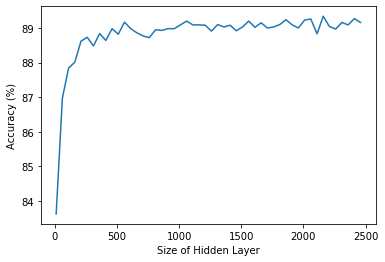

The best accuracy was 89.34 % for 2160 as size of the first hidden layer


In [28]:
plt.plot(N_D1,MAX_ACC)
plt.xlabel('Size of Hidden Layer')
plt.ylabel('Accuracy (%)')
plt.show()


print('The best accuracy was' , max(MAX_ACC),'% for',  N_D1[MAX_ACC.index(max(MAX_ACC))], 'as size of the first hidden layer')